In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"   #(xxxx is your specific GPU ID)

In [2]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Activation, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from MyEarlyStopping import MyEarlyStopping
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# from keras.optimizers import adam
from sklearn.metrics.pairwise import cosine_similarity
import timeit
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
from sklearn.preprocessing import LabelEncoder  
from sklearn.metrics import average_precision_score, precision_recall_curve

# load trained model

In [3]:
resnet_model = tf.keras.models.load_model('Digital_data_Initial_group_model_0531_free&unfree.h5')

In [4]:
Embedding_model = tf.keras.models.Model(inputs=resnet_model.input,
                                 outputs=resnet_model.get_layer("fc1_2").output)

## load data

In [5]:
All_data = ImageDataGenerator(preprocessing_function=preprocess_input)
All_data_generator = All_data.flow_from_directory('/data/home/cou/yuli5/Audio/online_data_adaption/Mel_Audio_folder_digits',
                                                batch_size=1,
                                                target_size=(224,224),
                                                class_mode='categorical',
                                               shuffle=False)

Found 30000 images belonging to 10 classes.


In [6]:
image_names = All_data_generator.filenames
image_no = [i.split("/")[1].split("_")[2].split(".")[0] for i in image_names]
image_no = np.array(list(map(int, image_no)))
ALL_participant_class = [i.split("/")[1].split("_")[1] for i in image_names]
ALL_participant_class = np.array(list(map(int, ALL_participant_class)))
command_class = All_data_generator.classes
All_participant_class = tf.keras.utils.to_categorical(ALL_participant_class-1, num_classes=60)
All_command_class = tf.keras.utils.to_categorical(command_class, num_classes=10)
All_command_uniform = All_command_class*0+1/10

In [7]:
All_Inputs = [next(All_data_generator)[0][0] for _ in range(len(All_data_generator))]
All_Inputs = np.array(All_Inputs)

In [8]:
# image_no<=20 means every word repeat 20 times 
s_number = 5 # ALL_participant_class  the subject index

select_indexs_train = (image_no<=19)&(ALL_participant_class<=s_number)
Train_Inputs = All_Inputs[select_indexs_train]
Train_participant_class = All_participant_class[select_indexs_train][:,0:s_number]
Train_participants = np.argmax(Train_participant_class, axis=1) +1
Train_participant_uniform = Train_participant_class*0+1/s_number
Train_command_class = All_command_class[select_indexs_train]
Train_command_uniform = Train_command_class*0+1/10

In [9]:
select_indexs_val = (image_no>29)&(image_no<=39)&(ALL_participant_class<=s_number)
Val_Inputs = All_Inputs[select_indexs_val]
Val_participant_class = All_participant_class[select_indexs_val][:,0:s_number]
Val_participant_uniform = Val_participant_class*0+1/s_number
Val_command_class = All_command_class[select_indexs_val]
Val_command_uniform = Val_command_class*0+1/10

In [10]:
select_indexs_test = (image_no>39)&(image_no<=49)&(ALL_participant_class<=s_number)
Test_Inputs = All_Inputs[select_indexs_test]
Test_participant_class = All_participant_class[select_indexs_test][:,0:s_number]
Test_participants = np.argmax(Test_participant_class, axis=1) +1
Test_participant_uniform = Test_participant_class*0+1/s_number
Test_command_class = All_command_class[select_indexs_test]
Test_command_uniform = Test_command_class*0+1/10

In [11]:
# external 51-60
select_indexs_External = (image_no>39)&(image_no<=49)&(ALL_participant_class>=51)
External_Inputs = All_Inputs[select_indexs_External]
External_participants = np.argmax(All_participant_class[select_indexs_External], axis=1) +1

# get average embedding value based on training data

In [12]:
# average all training subject embedding
embd_sub_1 = Embedding_model.predict(Train_Inputs[Train_participants==1]).mean(axis=0).reshape(1, -1)
embd_sub_2 = Embedding_model.predict(Train_Inputs[Train_participants==2]).mean(axis=0).reshape(1, -1)
embd_sub_3 = Embedding_model.predict(Train_Inputs[Train_participants==3]).mean(axis=0).reshape(1, -1)
embd_sub_4 = Embedding_model.predict(Train_Inputs[Train_participants==4]).mean(axis=0).reshape(1, -1)
embd_sub_5 = Embedding_model.predict(Train_Inputs[Train_participants==5]).mean(axis=0).reshape(1, -1)
embd_allsubs = Embedding_model.predict(Train_Inputs).mean(axis=0).reshape(1, -1)

# end-to-end speaker verification 

## calculation 

In [13]:
CosSimty = pd.DataFrame(columns=["Real_sub","cos_sub_1","cos_sub_2","cos_sub_3","cos_sub_4","cos_sub_5","cos_all"])

In [14]:
for i in range(1,6):
    test_Data = Test_Inputs[np.where(Test_participants == i)]
    temp = pd.DataFrame(columns=["Real_sub","cos_sub_1","cos_sub_2","cos_sub_3","cos_sub_4","cos_sub_5","cos_all"])
    temp["Real_sub"] = [i]*len( test_Data )
    temp["cos_sub_1"]= cosine_similarity(Embedding_model.predict( test_Data ), embd_sub_1)
    temp["cos_sub_2"]= cosine_similarity(Embedding_model.predict( test_Data ), embd_sub_2)
    temp["cos_sub_3"]= cosine_similarity(Embedding_model.predict( test_Data ), embd_sub_3)
    temp["cos_sub_4"]= cosine_similarity(Embedding_model.predict( test_Data ), embd_sub_4)
    temp["cos_sub_5"]= cosine_similarity(Embedding_model.predict( test_Data ), embd_sub_5)
    temp["cos_all"]= cosine_similarity(Embedding_model.predict( test_Data ), embd_allsubs)

    CosSimty = CosSimty.append(temp,ignore_index=True)

for i in range(51,61):
    test_Data = External_Inputs[np.where(External_participants == i)]
    temp = pd.DataFrame(columns=["Real_sub","cos_sub_1","cos_sub_2","cos_sub_3","cos_sub_4","cos_sub_5","cos_all"])
    temp["Real_sub"] = [i]*len( test_Data )
    temp["cos_sub_1"]= cosine_similarity(Embedding_model.predict( test_Data ), embd_sub_1)
    temp["cos_sub_2"]= cosine_similarity(Embedding_model.predict( test_Data ), embd_sub_2)
    temp["cos_sub_3"]= cosine_similarity(Embedding_model.predict( test_Data ), embd_sub_3)
    temp["cos_sub_4"]= cosine_similarity(Embedding_model.predict( test_Data ), embd_sub_4)
    temp["cos_sub_5"]= cosine_similarity(Embedding_model.predict( test_Data ), embd_sub_5)
    temp["cos_all"]= cosine_similarity(Embedding_model.predict( test_Data ), embd_allsubs)

    CosSimty = CosSimty.append(temp,ignore_index=True)


In [15]:
CosSimty.loc[CosSimty["Real_sub"]<6,"True_Label"]=0
CosSimty.loc[CosSimty["Real_sub"]>5,"True_Label"]=1

## verification using the average all

In [16]:
y_test = CosSimty["True_Label"]
y_score = 1 - CosSimty["cos_all"]

In [17]:
precision, recall, thresholds = precision_recall_curve(y_test,y_score)
average_precision = average_precision_score(y_test,y_score)

In [18]:
average_precision

0.6258350845756454

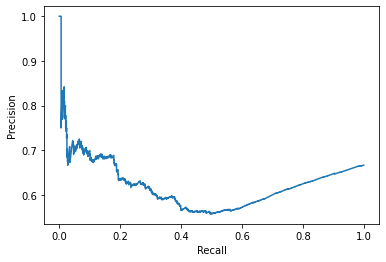

In [19]:
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

(0.3, 1.0)

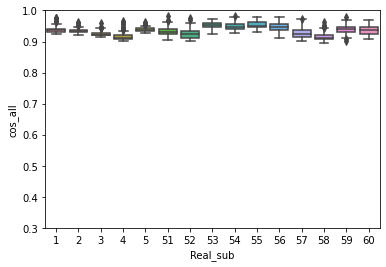

In [20]:
sns.boxplot(data=CosSimty, x="Real_sub",y="cos_all")
plt.ylim(0.3,1)

In [21]:
CosSimty.groupby(["Real_sub"]).mean()

,cos_sub_1,cos_sub_2,cos_sub_3,cos_sub_4,cos_sub_5,cos_all,True_Label
Real_sub,,,,,,,
1,0.989007,0.867725,0.807613,0.845965,0.863006,0.937919,0.0
2,0.863319,0.989208,0.818349,0.828024,0.859119,0.934574,0.0
3,0.807024,0.819273,0.993733,0.807297,0.885226,0.925270,0.0
4,0.845796,0.835200,0.810849,0.990150,0.793058,0.917289,0.0
5,0.860362,0.857947,0.879971,0.789261,0.992144,0.939358,0.0
51,0.879743,0.920304,0.800299,0.926180,0.821041,0.932566,1.0
52,0.875975,0.887446,0.792750,0.956194,0.801675,0.925471,1.0
53,0.865664,0.896609,0.915527,0.829300,0.935575,0.952942,1.0
54,0.862764,0.868108,0.935962,0.817761,0.942110,0.949561,1.0


In [22]:
Speaker_Verfication_Performance = pd.read_csv("Speaker_Verfication_Performance_0921_Externalas1.csv")
# Speaker_Verfication_Performance = pd.DataFrame()
data = pd.DataFrame()

In [23]:
data['Recall'] = recall
data['Precision'] = precision
data['Thresholds'] = np.append(thresholds,"nan")
data['Data'] =  'Digit Data'
data['Train Size'] =  '40%'
data['Speaker Number'] =  5
data['D-vector'] =  'fc1_2'
Speaker_Verfication_Performance = pd.concat([Speaker_Verfication_Performance,data], ignore_index=True)

In [24]:
Speaker_Verfication_Performance.to_csv('Speaker_Verfication_Performance_0921_Externalas1.csv',index=False)